In [1]:
import json 
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
# Import necessary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from scipy.stats import f
from matplotlib.colors import LogNorm, BoundaryNorm
from sklearn.preprocessing import MinMaxScaler
from matplotlib import cm
sns.set(font="Times New Roman")
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] =12 
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'Times New Roman'
})
#import itertools
def l_0_norm(vector):
    count = 0
    total = 0
    for element in vector:
        for sub_element in element:
            if sub_element != 0:
                count += 1
    return count
def take_average(dict):
    data = dict["0"]
    iterations_block = list(["0","1","2","3","4"])
    iterations_channel = list(["0","1","2","3","4"])
    #for style , iterations in zip (["channel","channel","block_random","channel_random"],[iterations_block,iterations_channel,iterations_block,iterations_channel]):
    for style , iterations in zip (["block","channel"],[iterations_block,iterations_channel,iterations_block,iterations_channel]):
        for iter in iterations:
            if iter == "0":
                continue
            for ratio in dict[iter][style]:
                for dataset in dict[iter][style][ratio]:
                    for norm in dict[iter][style][ratio][dataset]:
                        value = np.array(dict[iter][style][ratio][dataset][norm])
                        data[style][ratio][dataset][norm]= (np.array(data[style][ratio][dataset][norm])+value)
                        if iter == iterations[-1]:
                            data[style][ratio][dataset][norm] = data[style][ratio][dataset][norm]/len(iterations)

    return data
def strip(name):
    name = name.split("/")[-1]
    name = name.split("_")[0]
    return name 


def loop_over(dict):
    if isinstance(dict, list):
        print("end")
    else: 
        print(dict.keys())
        for keys in dict:
            loop_over(dict[keys])
def get_dataset_list(dataset_list):
    dataname = []
    for data in dataset_list:
        if "subset" not in dataset_list[data].keys():
            dataname.append(data)
        else:
            for subset in dataset_list[data]["subset"]:
                dataname.append(subset)
    return dataname

def get_community_dict(dataset_list, dataset_community):
    community_dict = {}
    for dataset in dataset_list:
        for comm in dataset_community:
            if dataset in list(dataset_community[comm].keys()):
                break
        community_dict[dataset] = int(comm)
    return community_dict

def get_cluster_dict(dataset_list, model_cluster):
    cluster_dict = {}
    for dataset in dataset_list:
        for clust in model_cluster:
            if dataset in list(model_cluster[clust]):
                break
        cluster_dict[dataset] = int(clust)
    return cluster_dict

#Dataset List
with open("/home/bhandk/MLNeuron/dataset_info.json", 'r') as openfile:
        # Reading from json file
        dataset_list = json.load(openfile)
#Original Distribution
with open("result/original_distribution_vicuna_7b.json", 'r') as openfile:
    vicuna_original = json.load(openfile)
with open("result/original_distribution_llama_7b.json", 'r') as openfile:
    # Reading from json file
    llama_original = json.load(openfile)
with open("result/original_distribution_llama_7b-chat.json", 'r') as openfile:
    # Reading from json file
    llama_chat_original = json.load(openfile)
#Pruned Distribution
with open("result/distribution_llama_7b.json", 'r') as openfile:
    # Reading from json file
    llama_distribution = json.load(openfile)
with open("result/distribution_vicuna_7b.json", 'r') as openfile:
    # Reading from json file
    vicuna_distribution = json.load(openfile)
with open("result/distribution_llama_7b-chat.json", 'r') as openfile:
    # Reading from json file
    llama_chat_distribution= json.load(openfile)
with open("result/dataNeuropsychologicalDomainsCluster.json", 'r') as openfile:
    # Reading from json file
    dataset_community= json.load(openfile)
dataset_list = get_dataset_list(dataset_list)
llama_distribution = take_average(llama_distribution)
vicuna_distribution = take_average(vicuna_distribution)
llama_chat_distribution = take_average(llama_chat_distribution)
community_dict = get_community_dict(dataset_list, dataset_community)

## Accuracy Plot

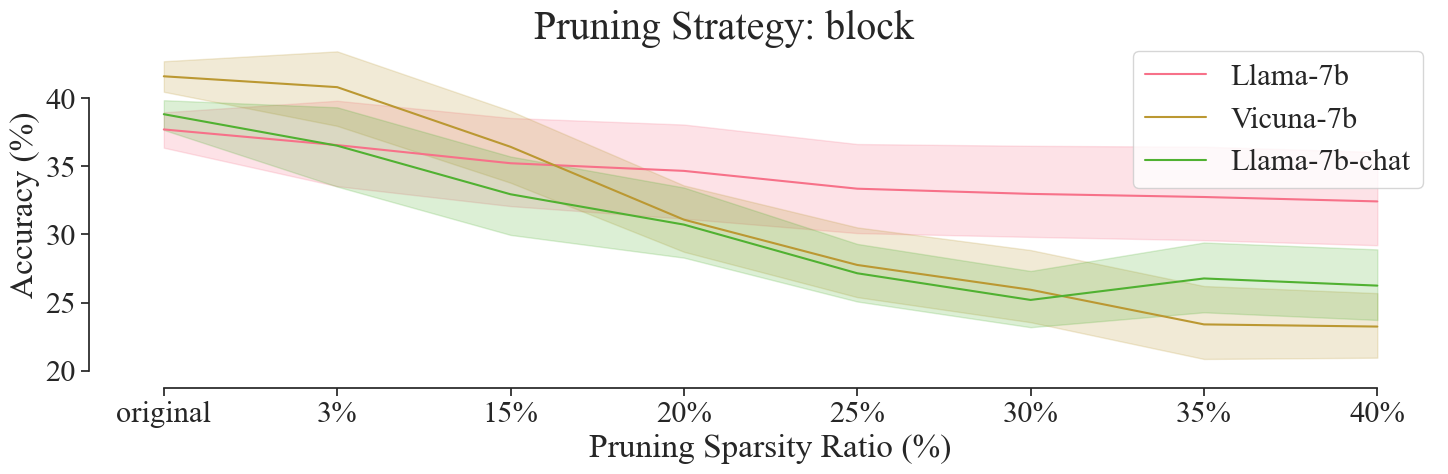

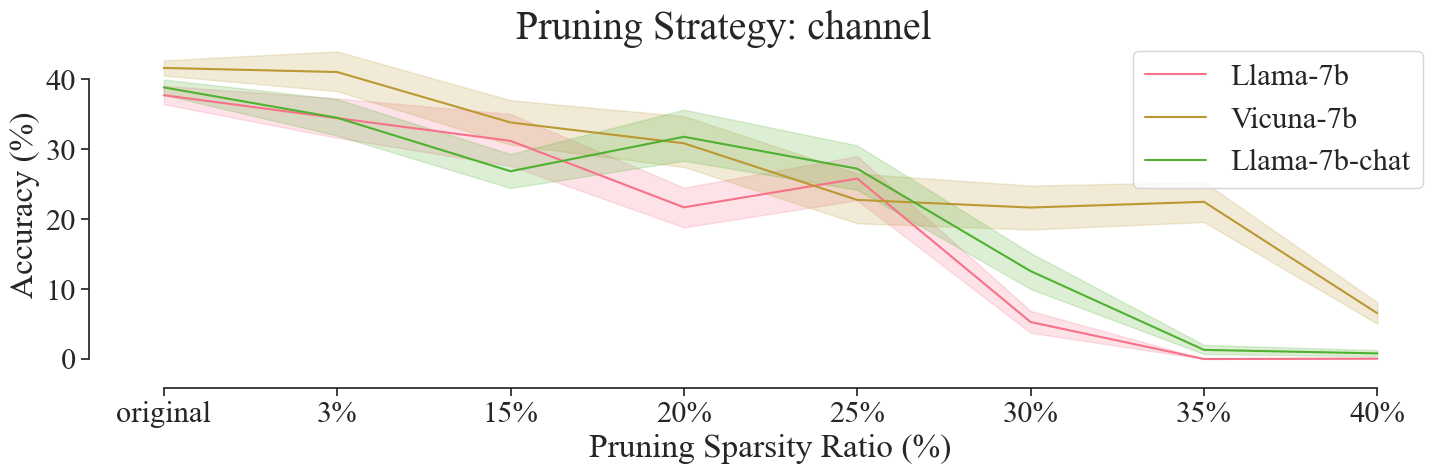

In [17]:
import pandas as pd
import seaborn as sns
from matplotlib import rc

# Set font to Times New Roman
rc('font', **{'family': 'serif', 'serif': ['Times New Roman'], 'size': 30})
rc('text', usetex=False)
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']
sns.set(font="'Times New Roman'")
def plot_accuracy(distribution_list,original_distribution_list,models_list,pruner_style="block", ratio_list=["15"]):
    data = {"Accuracy":[] ,"model":[], "ratio":[]}
    data["Accuracy"] = []
    for model_idx, model in enumerate(models_list):
        for pruner_ratio in ratio_list:
            for node in original_distribution_list[model_idx]:
                node= node.split("/")[-1]
                if node in ["distribution"]:
                    continue
                pruned_acc = original_distribution_list[model_idx][node][-1] * 100
                data["Accuracy"].append(pruned_acc)
                data["ratio"].append(f"original" )
                data["model"].append(f"{model}")

    for model_idx, model in enumerate(models_list):
        for pruner_ratio in ratio_list:
            if pruner_ratio not in distribution_list[model_idx][pruner_style].keys():
                continue
            for node in distribution_list[model_idx][pruner_style][pruner_ratio]:
                node= node.split("/")[-1]
                pruned_acc = distribution_list[model_idx][pruner_style][pruner_ratio][node]["Accuracy"][-1] * 100
                data["Accuracy"].append(pruned_acc)
                data["ratio"].append(f"{pruner_ratio}%" )
                data["model"].append(f"{model}")
    data = pd.DataFrame.from_dict(data)
    plt.figure(figsize=(15,5))
    #sns.set_theme(style="ticks", palette="pastel")  
    sns.set_theme(style="ticks", palette="husl",font='Times New Roman',font_scale=2,color_codes='b')  
    #sns.boxplot(x="model", y="accuracy", hue="ratio",hue_order=["original"]+[f"{pruner_ratio}%" for pruner_ratio in ratio_list],data=data, width=.5)
    #sns.boxplot(x="ratio", y="accuracy", hue="model",hue_order=models_list ,data=data, width=.5)
    g =sns.lineplot(x="ratio", y="Accuracy", hue="model",hue_order=models_list ,data=data)
    sns.despine(offset=10, trim=True)
    g.legend_.set_title(None)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Pruning Sparsity Ratio (%)")
    plt.tight_layout()
    plt.savefig(f"./figure/accuracy_{pruner_style}.pdf",dpi=300)
    plt.suptitle(f"Pruning Strategy: {pruner_style}")
    plt.show()

def plot_acc_based_community(distribution,original_distribution,plot_title,pruner_style="block", ratio_list=["15"]):
    with open("result/dataNeuropsychologicalDomainsCluster.json", 'r') as openfile:
        # Reading from json file
        cluster_dataset_list = json.load(openfile)
    data = {"accuracy":[] ,"ratio":[], "cognitive category":[]}
    data["accuracy"] = []
    #label= ["spatial\ncognition", "social\ncognition", "mathematical\ncognition", "linguistic\ncognition", "logical reasoning\ncogntition", "random"]
    for comm_idx, comm in enumerate(cluster_dataset_list):
        for idx, pruner_ratio in enumerate(ratio_list):
            if pruner_ratio not in distribution[pruner_style].keys():
                continue
            for node in cluster_dataset_list[comm]:
                node= node.split("/")[-1]
                pruned_acc = distribution[pruner_style][pruner_ratio][node]["Accuracy"][-1]
                data["accuracy"].append(pruned_acc)
                data["ratio"].append(f"{pruner_ratio}%" )
                data["cognitive category"].append(f"{comm_idx}")
                if idx == 0:
                    org_comm_acc = (original_distribution[node][-1])
                    data["accuracy"].append(org_comm_acc)
                    data["ratio"].append("original")
                    data["cognitive category"].append(f"{comm_idx}")
    data = pd.DataFrame.from_dict(data)
    plt.figure(figsize=(10,5))
    sns.set_theme(style="ticks", palette="pastel")  
    g = sns.boxplot(x="cognitive category", y="accuracy", hue="ratio",hue_order=["original"]+[f"{pruner_ratio}%" for pruner_ratio in ratio_list],data=data, width=.5)
    g.legend_.set_title(None)
    sns.despine(offset=10, trim=True)
    
    plt.suptitle(f"Model: {plot_title} | Pruning Strategy: {pruner_style}")
    plt.show()
#plot_acc_based_community(llama_distribution,llama_original,plot_title = "Llama-7b", pruner_style="block", ratio_list=["3","15","20","25","30","35","40"])
#plot_acc_based_community(vicuna_distribution,vicuna_original,plot_title = "Vicuna-7b",pruner_style="block", ratio_list=["3","15","20","25","30","35","40"])
#plot_acc_based_community(llama_chat_distribution,llama_chat_original,plot_title = "Llama-7b-chat",pruner_style="block", ratio_list=["3","15","20","25","30","35","40"])
distribution_list= [llama_distribution,vicuna_distribution,llama_chat_distribution]
original_distribution_list= [llama_original,vicuna_original,llama_chat_original]
models_list=["Llama-7b","Vicuna-7b", "Llama-7b-chat"]
plot_accuracy(distribution_list,original_distribution_list,models_list,pruner_style="block",ratio_list=["3","15","20","25","30","35","40"])
plot_accuracy(distribution_list,original_distribution_list,models_list,pruner_style="channel",ratio_list=["3","15","20","25","30","35","40"])


# PCA and t-SNE comparison

## All Flatten to a single layer and use KMeans for cluster

In [3]:
'''def visualize(number_cluster, all_data,X_pca,clusters_pca,random_pca=[], style="channel", ratio="15"):
        cmap = plt.cm.tab20  # define the colormap
        # extract all colors from the .jet map
        cmaplist = [cmap(i) for i in range(cmap.N)]
        # force the first color entry to be grey
        cmaplist[0] = (.5, .5, .5, 1.0)

        # create the new map
        cmap = mpl.colors.LinearSegmentedColormap.from_list(
            'Custom cmap', cmaplist, cmap.N)

        # define the bins and normalize
        bounds = np.linspace(0, number_cluster,number_cluster+1)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)



        indexes_pca = [(x,np.where(clusters_pca == x)[0]) for x in set(clusters_pca)]
        lw = 2
        figure, axis = plt.subplots(figsize=(8, 6))
        if len(random_pca) != 0:
            axis.scatter(random_pca[:, 0],  random_pca[:, 1], color = "black",label="Random")
        axis.scatter(X_pca[:, 0],  X_pca[:, 1], c=clusters_pca,
                  cmap=cmap, norm=norm,alpha=.8, lw=lw)
        #axis[1].scatter(X_tsne[1:, 0],X_tsne[1:, 1], c=clusters_tsne[1:],cmap=cmap, norm=norm,alpha=.8, lw=lw)
        
        #ax2 = figure.add_axes([0.95, 0.1, 0.03, 0.8])
        ax2 = figure.add_axes([0.99, 0.1, 0.03, 0.8])
        cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, spacing='proportional', ticks=[b+0.5 for b in bounds], boundaries=bounds, format='%1i')

        axis.set_title(f"PCA")

        figure.suptitle(f"Strategy: {style} | Ratio: {ratio} | Cluster: {number_cluster}")
        for cluster, index in indexes_pca:
            axis.annotate(all_data[index[0]], (X_pca[index[0],0], X_pca[index[0],1]))
            try:
                axis.annotate(all_data[index[1]], (X_pca[index[1],0], X_pca[index[1],1]))
            except:
                continue
        axis.axhline(0)
        axis.axvline(0)
        axis.legend()
        cluster= {}
        for cluster_name, indexes  in indexes_pca:
            cluster[cluster_name] = [all_data[i] for i in indexes]
        plt.show()
        return cluster'''
from matplotlib.patches import Ellipse




def visualize(Kmean, all_data,X_pca,clusters_pca,random_pca=[], style="channel", ratio="15", plot=False, original =False, random =False):
        data = {"pca1":[],"pca2":[],"cluster":[],"dataset_name":[]}
        extra = [ ]
        for idx, (pca, cluster) in enumerate(zip(X_pca,clusters_pca)):
            if original and idx == 0:
                data["pca1"].append(pca[0])
                data["pca2"].append(pca[1])
                data["cluster"].append("original")
                data["dataset_name"].append("original")
                extra.append("original")
            else:
                data["pca1"].append(pca[0])
                data["pca2"].append(pca[1])
                data["cluster"].append(cluster)
                data["dataset_name"].append(all_data[idx])
        if random:
             for idx, pca in enumerate(random_pca):
                data["pca1"].append(pca[0])
                data["pca2"].append(pca[1])
                data["cluster"].append("random")
                data["dataset_name"].append(all_data[idx])
                extra.append("random")
        indexes_pca = [(x,np.where(clusters_pca == x)[0]) for x in set(clusters_pca)]
        lw = 2

        if plot:
            plt.figure(figsize=(12, 10))
            sns.scatterplot(data=data, x="pca1", y="pca2", hue="cluster",hue_order=list(set(clusters_pca))+list(set(extra)), palette="deep", style="cluster")
            #plt.title(f"Strategy: {style} | Ratio: {ratio}% | Cluster: {number_cluster}")
            centers = Kmean.cluster_centers_
            plt.scatter(centers[:, 0], centers[:, 1], c='red', s=300, alpha=0.6, edgecolors='w')
            def draw_ellipse(position, covariance, ax=None, **kwargs):
                    ax = ax or plt.gca()
                    if covariance.shape == (2, 2):
                        U, s, Vt = np.linalg.svd(covariance)
                        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
                        width, height = 2 * np.sqrt(s)
                    else:
                        angle = 0
                        width, height = 2 * np.sqrt(covariance)
                    
                    for nsig in range(1, 4):
                        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))
            #for i, mean in enumerate(Kmean.cluster_centers_):
            #    cov = np.cov(data[data['cluster'] == i][['pca1', 'pca2']].T)
            #    draw_ellipse(mean, cov, alpha=0.2, color='k')

            

            plt.grid()
            plt.axhline(0, color='black')
            plt.axvline(0, color='black')
            plt.legend()
            plt.show()
        cluster= {}
        for cluster_name, indexes  in indexes_pca:
            cluster[cluster_name] = [all_data[i] for i in indexes]
        return cluster, pd.DataFrame.from_dict(data)

# Statistical testing

In [4]:
from hotelling.stats import hotelling_t2

def hotelling_t2_test(data_A, data_B):
    # Calculate mean and covariance matrices for each dataset
    mean_A = np.mean(data_A, axis=0)
    mean_B = np.mean(data_B, axis=0)

    cov_A = np.cov(data_A, rowvar=False)
    cov_B = np.cov(data_B, rowvar=False)

    # Number of samples in each dataset
    n_A = len(data_A)
    n_B = len(data_B)

    # Pooled covariance matrix
    pooled_cov = ((n_A - 1) * cov_A + (n_B - 1) * cov_B) / (n_A + n_B - 2)

    # Calculate the T-squared statistic
    t_squared = n_A * n_B / (n_A + n_B) * np.dot(np.dot((mean_A - mean_B).T, np.linalg.inv(pooled_cov)), (mean_A - mean_B))

    # Degrees of freedom for the F-distribution
    df1 = data_A.shape[1]
    df2 = n_A + n_B - data_A.shape[1] - 1

    # p-value from the F-distribution
    p_value = 1 - f.cdf(t_squared * (n_A + n_B - 2) / (n_A * df1), df1, df2)

    return t_squared, p_value

def masking(test_list, item):
    res_list = []
    for i in range(0, len(test_list)):
        if test_list[i] == item:
            res_list.append(True)
        else:
            res_list.append(False)
    return res_list

def hotelling_t2_test_clusters(X, clusters):
    # Identify unique clusters
    unique_clusters = list(set(clusters))
    # Perform Hotelling's T-squared test for each pair of clusters
    data = np.zeros((len(unique_clusters),len(unique_clusters)))
    save_p_value = []
    save_mean_value = []
    for idx_i, i in enumerate(unique_clusters):
        p_value_list = []
        mean_value_list = []
        for idx_j, j in enumerate(unique_clusters):
            if idx_j > idx_i :
                p_value_list.append(0)
                mean_value_list.append(0)
                continue
            # Extract data for each cluster
            
            cluster_i_data = X[masking(clusters,i)]
            cluster_j_data = X[masking(clusters,j)]
            t_squared_stat, f_value, p_value, _ = hotelling_t2(cluster_i_data, cluster_j_data)
            p_value_list.append(p_value)
            mean_value_list.append(t_squared_stat)
        save_p_value.append(p_value_list)
        save_mean_value.append(mean_value_list)

    figure, axis = plt.subplots(figsize=(12, 8), ncols=2)
    p_value = np.array(save_p_value)
    mean_value = np.array(save_mean_value)
    mask = np.triu(np.ones_like(p_value))#-np.eye(p_value.shape[0],p_value.shape[1])
    # using the upper triangle matrix as mask 
    sns.heatmap(p_value, annot=True, fmt='.1e' , ax=axis[1],xticklabels=unique_clusters, yticklabels=unique_clusters,mask=mask)
    axis[1].set_title("P-value")
    sns.heatmap(mean_value, annot=True, fmt='.1e' , ax=axis[0],xticklabels=unique_clusters, yticklabels=unique_clusters,mask=mask)
    axis[0].set_title("Statistics")
    figure.suptitle(f"Hotelling's T-squared Statistic")

    plt.plot()
    return p_value, mean_value, unique_clusters 


In [5]:
from sklearn.cluster import SpectralClustering
def k_means_and_pca(X,n_cluster,do_tranform = False):
        if do_tranform:
            # Standardize the feature matrix (mean center and scale)
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
        else:
            X_scaled = X #X#scaler.fit_transform(X)
        # Perform PCA
        n_components = 2  # Number of components to keep
        kmeans = KMeans(n_init="auto",n_clusters=n_cluster, random_state=0)  # KMEANS
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X_scaled)
        #Random_pca = pca.fit_transform(Random)
        clusters_pca = kmeans.fit_predict(X_pca)
        return X_pca, clusters_pca, kmeans

def k_means_and_spectral_clustering(X,n_cluster,do_tranform = False):
        if do_tranform:
            # Standardize the feature matrix (mean center and scale)
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
        else:
            X_scaled = X #X#scaler.fit_transform(X)
        # Perform PCA
        n_components = 2  # Number of components to keep
        sc = SpectralClustering(n_clusters=n_cluster, affinity='nearest_neighbors', assign_labels='kmeans')
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X_scaled)
        clusters_sc = sc.fit_predict(X_pca)
        #Random_pca = pca.fit_transform(Random)
        return X_pca, clusters_sc

def plot_cluster_distribution(model_label,llm_pruner, original_distribution, dataset_list, ratio="15",norm = "|W|_0" ,style="channel",add_original=False,add_random = False, plot=False,hotelling_test=False):
    layers = np.arange(0,32,1)[3:31]
    
    #for module in ["|W|_0","|W|_F"]:
    best_idx_pca = 10000 
    store_pca= []
    store_cluster= []
    best_clusters_pca = None
    best_X_pca = None
    best_cluster_size = None
    
    for NUM_CLUSTER in [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]:
        #for NUM_CLUSTER in [3]:
        original = np.array(original_distribution["distribution"][norm])[layers,:]
        label = [ ]
        label_idx = []
        Random = []
        for idx, dataset_name in enumerate(dataset_list):
            dataset = dataset_name.split('/')[-1]
            label.append(dataset)
            label_idx.append(idx)
            if idx == 0:
                if add_original:
                    X = original.flatten().reshape(-1,1).T
                else:
                    X_new = (np.array(llm_pruner[style][ratio][dataset][norm])[layers,:])
                    X =  X_new.flatten().reshape(-1,1).T
                    if add_random:
                        X_new =  np.array(llm_pruner[style+"_random"][ratio][dataset][norm])[layers,:]
                        Random = X_new.flatten().reshape(-1,1).T
                continue
            try:
                X_new =  np.array(llm_pruner[style][ratio][dataset][norm])[layers,:]
            except:
                print([style],[ratio],[dataset],[norm])
                X_new =  np.array(llm_pruner[style][ratio][dataset][norm])[layers,:]
            X_new = X_new.flatten().reshape(-1,1).T
            X = np.append(X, X_new, axis=0)
            if add_random:
                if len(Random) != 0:
                    X_new =  np.array(llm_pruner[style+"_random"][ratio][dataset][norm])[layers,:].flatten().reshape(-1,1).T
                    Random = np.append(Random, X_new, axis=0)
                else:
                    Random =  np.array(llm_pruner[style+"_random"][ratio][dataset][norm])[layers,:].flatten().reshape(-1,1).T
        if add_random:
            dataset_list_label = dataset_list +["random"] * Random.shape[0]
            X = np.append(X, Random, axis=0)
        
        X_pca, clusters_pca, kmeans = k_means_and_pca(X,NUM_CLUSTER)
        db_index_pca = davies_bouldin_score(X_pca, clusters_pca)
        store_pca.append(db_index_pca)
        store_cluster.append(NUM_CLUSTER)
        
        if db_index_pca < best_idx_pca:
            best_idx_pca = db_index_pca  
            best_X_pca = X_pca 
            best_clusters_pca =  clusters_pca
            best_cluster_size = NUM_CLUSTER           
            optimal_kmean = kmeans
            
    if plot:
        #plt.figure(figsize=(12, 10))
        df = pd.DataFrame.from_dict({"num_cluster":store_cluster,"davies_bouldin_score":store_pca})
        df.to_csv(f"result/kmeans_clustering_hotellings/{model_label}_{style}_{ratio}_davies_bouldin_score.csv",  index=False)
        plt.plot(store_cluster,store_pca,color="blue")
        plt.scatter(best_cluster_size,best_idx_pca,marker="o",label="Optimal",color="red")
        plt.xlabel("Number of Cluster")
        plt.ylabel("Davies Bouldin Score")
        #plt.title("Finding the Optimal Number of Cluster")
        plt.legend()
        plt.plot()
        print("="*1000)  
    if hotelling_test:
        print("Computing statistical testing")
        #t_squared_stat, p_value = hotelling_t2_test(best_X_pca[:len(dataset_list_label),:], best_X_pca[len(dataset_list_label):-1,:])
        if add_random:
            best_clusters_pca = list(best_clusters_pca)
            for i in range(len(Random),len(dataset_list_label)):
                best_clusters_pca[i] = "random"

        if add_original:
            best_clusters_pca = list(best_clusters_pca)
            best_clusters_pca[0] = "original"
        p_value, stats, uniq = hotelling_t2_test_clusters(best_X_pca, best_clusters_pca)
        for hotelling_test_result, hotelling_label in zip([p_value, stats],["p_value", "stats"]):
            df = pd.DataFrame(hotelling_test_result, index=uniq, columns=uniq)
            rand_label = "_rand" if add_random else ""
            df.to_csv(f"result/kmeans_clustering_hotellings/{model_label}_{style}_{ratio}{rand_label}_{hotelling_label}.csv",index=False)
        #hotelling_t2_test_clusters(best_X_pca, np.append(best_clusters_pca,np.array([max(best_clusters_pca)+1]*len(Random))))
        #print("Hotelling's T-squared Statistic:", t_squared_stat)
        #print("P-value:", p_value)
    if add_random:
        cluster,pd_data = visualize(optimal_kmean, dataset_list_label,best_X_pca[:len(dataset_list)-1,:],best_clusters_pca, random_pca=best_X_pca[len(dataset_list)-1:-1,:], style=style, ratio=ratio, plot=plot,original=add_original,random = add_random)
        rand_label = "_rand" 
    else:
        cluster,pd_data = visualize(optimal_kmean, dataset_list,best_X_pca[:len(dataset_list),:],best_clusters_pca, style=style, ratio=ratio, plot=plot,original=add_original,random = add_random)
        rand_label = "" 
    pd_data.to_csv(f"result/kmeans_clustering_hotellings/{model_label}_{style}_{ratio}{rand_label}_clustering.csv",index=False)
    return cluster
    


In [ ]:
model_cluster = plot_cluster_distribution("llama",llama_distribution, llama_original,dataset_list,ratio="20",style="block",add_original=False,add_random=True,plot=True,hotelling_test=True)
model_cluster = plot_cluster_distribution("llama_chat",llama_chat_distribution, llama_chat_original,dataset_list,ratio="15",style="block",add_original=False,add_random=True,plot=True,hotelling_test=True)
model_cluster = plot_cluster_distribution("vicuna",vicuna_distribution, vicuna_original,dataset_list,ratio="15",style="block",add_original=False,add_random=True,plot=True,hotelling_test=True)


In [ ]:
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import rand_score, jaccard_score
from sklearn.metrics import fowlkes_mallows_score
plt.clf()
pruning_strategy = "block"
value_list =[]
value_list_sklearn_ars =[]
value_list_sklearn_jaccard_index =[]
value_list_sklearn_fms =[]
value_list_sklearn_nmi =[]
ratio_list = ["3","15","20","25","30","35","40"]
for ratio in ratio_list:
    model_cluster = plot_cluster_distribution(llama_distribution, llama_original,dataset_list,ratio=ratio,style=pruning_strategy,add_original=False)
    model_dict = get_cluster_dict(dataset_list,model_cluster)
    #value = nmi(dataset_list, model_dict, community_dict)
    #value_list.append(value)
    value_list_sklearn_ars.append(rand_score([ community_dict[dataset] for dataset in dataset_list], [ model_dict[dataset] for dataset in dataset_list]))
    value_list_sklearn_jaccard_index.append(jaccard_score([ community_dict[dataset] for dataset in dataset_list], [ model_dict[dataset] for dataset in dataset_list],average='weighted'))
    value_list_sklearn_fms.append(fowlkes_mallows_score([ community_dict[dataset] for dataset in dataset_list], [ model_dict[dataset] for dataset in dataset_list]))
    value_list_sklearn_nmi.append(normalized_mutual_info_score([ community_dict[dataset] for dataset in dataset_list], [ model_dict[dataset] for dataset in dataset_list]))
plt.figure(figsize=(8,5))
plt.plot([f"{ratio}%" for ratio in ratio_list],value_list_sklearn_jaccard_index, color="green", label="rand_score")
#plt.plot([f"{ratio}%" for ratio in ratio_list],value_list_sklearn_fms, color="orange", label="fowlkes_mallows_score")
#plt.plot([f"{ratio}%" for ratio in ratio_list],value_list_sklearn_nmi, color="red", label="normalized_mutual_info_score")
#plt.plot([f"{ratio}%" for ratio in ratio_list],value_list_sklearn_ars, color="blue", label="rand_score")
plt.ylabel("rand_score")
plt.ylim([0,1])
plt.xlabel("Model Pruning Ratio")
plt.legend(loc = "upper right")
plt.title(f"Llama 7b | {pruning_strategy} Strategy")
plt.show()
print("="*100)
value_list_sklearn_nmi =[]
value_list_sklearn_jaccard_index =[]
value_list_sklearn_fms =[]
value_list_sklearn_ars =[]
for ratio in ratio_list:
    model_cluster = plot_cluster_distribution(vicuna_distribution, vicuna_original,dataset_list,ratio=ratio,style=pruning_strategy,add_original=False)
    model_dict = get_cluster_dict(dataset_list,model_cluster)
    #value = nmi(dataset_list, model_dict, community_dict)
    #value_list.append(value)
    value_list_sklearn_ars.append(rand_score([ community_dict[dataset] for dataset in dataset_list], [ model_dict[dataset] for dataset in dataset_list]))
    value_list_sklearn_jaccard_index.append(jaccard_score([ community_dict[dataset] for dataset in dataset_list], [ model_dict[dataset] for dataset in dataset_list],average='weighted'))
    value_list_sklearn_fms.append(fowlkes_mallows_score([ community_dict[dataset] for dataset in dataset_list], [ model_dict[dataset] for dataset in dataset_list]))
    value_list_sklearn_nmi.append(normalized_mutual_info_score([ community_dict[dataset] for dataset in dataset_list], [ model_dict[dataset] for dataset in dataset_list]))
plt.figure(figsize=(8,5))
plt.plot([f"{ratio}%" for ratio in ratio_list],value_list_sklearn_jaccard_index, color="green", label="rand_score")
#plt.plot([f"{ratio}%" for ratio in ratio_list],value_list_sklearn_fms, color="orange", label="fowlkes_mallows_score")
#plt.plot([f"{ratio}%" for ratio in ratio_list],value_list_sklearn_nmi, color="red", label="normalized_mutual_info_score")
#plt.plot([f"{ratio}%" for ratio in ratio_list],value_list_sklearn_ars, color="blue", label="rand_score")
plt.ylabel("rand_score")
plt.xlabel("Model Pruning Ratio")
plt.ylim([0,1])
plt.legend(loc = "upper right")
plt.title(f"Vicuna 7b | {pruning_strategy} Strategy")
plt.show()
print("="*100)
value_list_sklearn_nmi =[]
value_list_sklearn_jaccard_index =[]
value_list_sklearn_fms =[]
value_list_sklearn_ars =[]
for ratio in ratio_list:
    model_cluster = plot_cluster_distribution(llama_chat_distribution, llama_chat_original,dataset_list,ratio=ratio,style=pruning_strategy,add_original=False)
    model_dict = get_cluster_dict(dataset_list,model_cluster)
    #value = nmi(dataset_list, model_dict, community_dict)
    #value_list.append(value)
    value_list_sklearn_ars.append(rand_score([ community_dict[dataset] for dataset in dataset_list], [ model_dict[dataset] for dataset in dataset_list]))
    value_list_sklearn_jaccard_index.append(jaccard_score([ community_dict[dataset] for dataset in dataset_list], [ model_dict[dataset] for dataset in dataset_list],average='weighted'))
    value_list_sklearn_fms.append(fowlkes_mallows_score([ community_dict[dataset] for dataset in dataset_list], [ model_dict[dataset] for dataset in dataset_list]))
    value_list_sklearn_nmi.append(normalized_mutual_info_score([ community_dict[dataset] for dataset in dataset_list], [ model_dict[dataset] for dataset in dataset_list]))
plt.figure(figsize=(8,5))
plt.plot([f"{ratio}%" for ratio in ratio_list],value_list_sklearn_jaccard_index, color="green", label="rand_score")
#plt.plot([f"{ratio}%" for ratio in ratio_list],value_list_sklearn_fms, color="orange", label="fowlkes_mallows_score")
#plt.plot([f"{ratio}%" for ratio in ratio_list],value_list_sklearn_nmi, color="red", label="normalized_mutual_info_score")
#plt.plot([f"{ratio}%" for ratio in ratio_list],value_list_sklearn_ars, color="blue", label="rand_score")
plt.ylabel("rand_score")
plt.ylim([0,1])
plt.xlabel("Model Pruning Ratio")
plt.legend(loc = "upper right")
plt.title(f"Llama Chat 7b | {pruning_strategy} Strategy")
plt.show()
print("="*100)
